In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import  DataLoader, TensorDataset
import mlflow
import os
from torch.utils.tensorboard import SummaryWriter


In [2]:

def get_data_loader():
    # load the dataset
    dataset = pd.read_csv('pima-indians-diabetes.csv').to_numpy()

    # split into input (X) and output (y) variables
    X = dataset[:, 0:8]
    y = dataset[:, 8]

    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)

    dataset_xy = TensorDataset(X, y)
    return DataLoader(dataset=dataset_xy, batch_size=16, shuffle=True)



In [3]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 8)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, 8)
        self.out = nn.Linear(8, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        x = self.fc1(input_)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = self.out_act(x)
        return x

In [4]:

def log_scalar(val,name,epoch,mlflow_log=True):
    tensor_logger.add_scalar(name,val,epoch)
    if mlflow_log:
        mlflow.log_metric(name,val)


In [5]:

def train_epoch(model, opt, criterion, train_loader):
    model.train()
    losses = []
    for idx, data in enumerate(train_loader):
        x_batch,y_batch = data
        x_batch = x_batch.to(device)

        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat.cpu().squeeze(), y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.data.numpy())

        log_scalar(loss.data.item(),"loss",e,mlflow_log=True)

    return losses

Using device: cpu


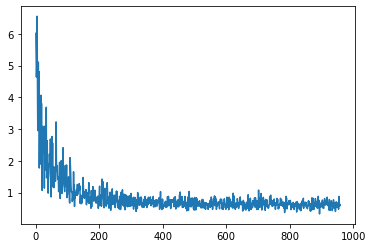

In [6]:

tensor_logger = SummaryWriter(filename_suffix="_torch")
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
e_losses = []
num_epochs = 20
my_loader = get_data_loader()

with mlflow.start_run():
    mlflow.log_param("model", "Net1")
    mlflow.set_tag("Version", 1)
    for e in range(num_epochs):
        e_losses += train_epoch(net, opt, criterion, my_loader)

    mlflow.log_artifact("pima-indians-diabetes.csv")
    mlflow.pytorch.log_model(net,artifact_path="my_net")
    plt.plot(e_losses)
    plt.show()
    mlflow.end_run()
